# Frequency-domain API for jaxNR

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from matplotlib import pyplot as plt
from jaxnrsur.NRSur7dq4 import NRSur7dq4Model
import jax.numpy as jnp

## Existing API

Evaluate traditional surrogate

In [3]:
# data = h5py.File('./NRHybSur3dq8.h5','r')

# node_data = data['sur_subs/ITEM_8/func_subs/ITEM_0/node_functions/ITEM_0/node_function/DICT_fit_data']
# res = ReadNode.read_node_fit_info_from_h5(node_data)
# res['GPR_params']['_y_train_std'] = 1
# evaluator = getFitEvaluator(res)
# random_input = np.random.uniform(0,1, size=(100,1,3))

# eim_predictor = EIMpredictor(res)
# eim_predict = eim_predictor.make_predict()
# eim_predict = jax.jit(jax.vmap(eim_predict))

# # Evaluate traditional surrogate
# tsur, hsur, sur_time, h_amp, h_phase = evalSur.simple_sur_evaluator(q_input=1, chi1_input=0, chi2_input=0, H5_DATA_PATH='./')
# h_nonjax = h_amp*jnp.exp(1j*h_phase)

Evaluate Jax surrogate

In [4]:
# Evaluate jax surrogate
time = jnp.linspace(-1000, 100, 100000)
params = jnp.array([0.9, 0.0, 0.5, 0.0, 0.5, 0.0, 0.3])
model = NRSur7dq4Model()
h_jax = model(time, params)

Try loading file from cache
Cache found and loading data


/Users/misi/src/JaxNRSur/.venv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'numpy.complexfloating'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


ValueError: Vector and operator structures do not match. Got a vector with structure ShapeDtypeStruct(shape=(2000,), dtype=complex64) and an operator with out-structure ShapeDtypeStruct(shape=(2000,), dtype=float32)

This is the complex strained, encoding plus and cross in the time domain.

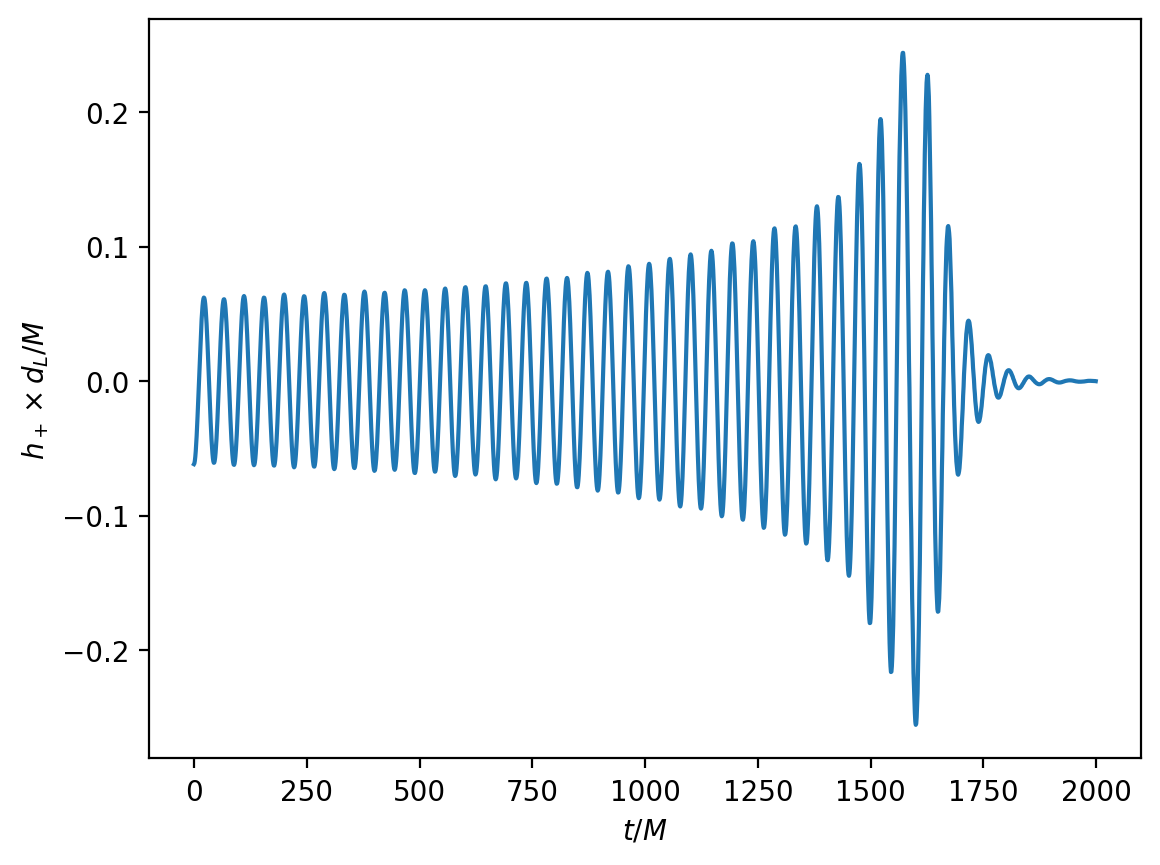

In [ ]:
# m = sur_time > -500
# plt.plot(sur_time[m], h_nonjax.real[m])
plt.plot(h_jax.real)
plt.xlabel("$t/M$")
plt.ylabel(r"$h_+ \times d_L/M$");

## Dimensionful API

We now want an API to obtain an FD waveform, for preset sampling rate and duration in SI units. This requires:
1. evaluating jaxNRSur over a suitable time array (right `srate` and `seglen`)
2. windowing, mindful of potential wrap-around
3. FFTing

We'll create one function for 1 and 2, and a wrapper for 3. The first item will require translating from geometric to SI units using the total mass.

To construct the time array, we will follow the LAL convention that the trigger time will be placed 2s before the end of the segment.

In [11]:
# geometric units to SI
GMSUN_SI = 1.32712442099000e+20
C_SI = 2.99792458000000e+08
RSUN_SI = GMSUN_SI / C_SI**2

# parsecs to SI
PC_SI = 3.08567758149136720000e+16
MPC_SI = 1E6*PC_SI

### Time domain

In [12]:
def get_jaxnr_td(srate, seglen, params):
    """Wrapper for jaxNR to produce waveform over given dimensionful time.
    """
    # get scaling parameters
    mtot = params[0]
    dist_mpc = params[1]
    
    # form time array with desired sampling rate and duration
    N = int(seglen*srate)
    time = jnp.arange(N)/srate - seglen + 2
    
    # evaluate the surrogate over the equivalent geometric time
    time_m = time * C_SI / RSUN_SI / mtot
    hrM = model(time_m, jnp.array(params[2:]))
    
    # this is h * r / M, so scale by the mass and distance
    h = hrM * mtot * RSUN_SI / dist_mpc / MPC_SI
    return h, time

Test the function on some GW150914-like parameters:

/Users/misi/src/JaxNRSur/.venv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'numpy.complexfloating'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


ValueError: x and y must have same first dimension, but have shapes (8192,) and (2000,)

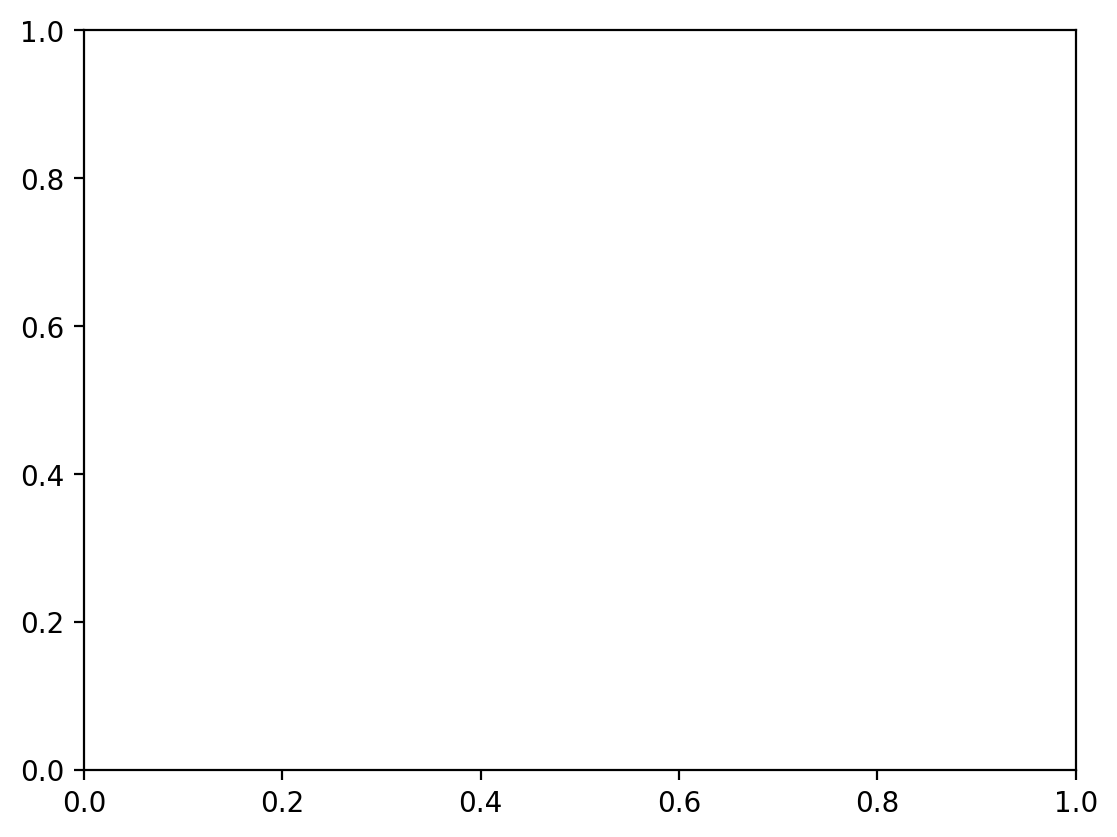

In [14]:
params = [0.9, 0.0, 0.5, 0.0, 0.5, 0.0, 0.3]
h, t = get_jaxnr_td(2048, 4, [100, 400.]+params)

plt.plot(t, h.real)
plt.xlabel("$t/s$")
plt.ylabel(r"$h_+ \times d_L/M$");

That's all we need to window and then FFT, **EXCEPT** that if the initial waveform is too short, then it will start abruptly and will not get windowed when FFTing, e.g.,

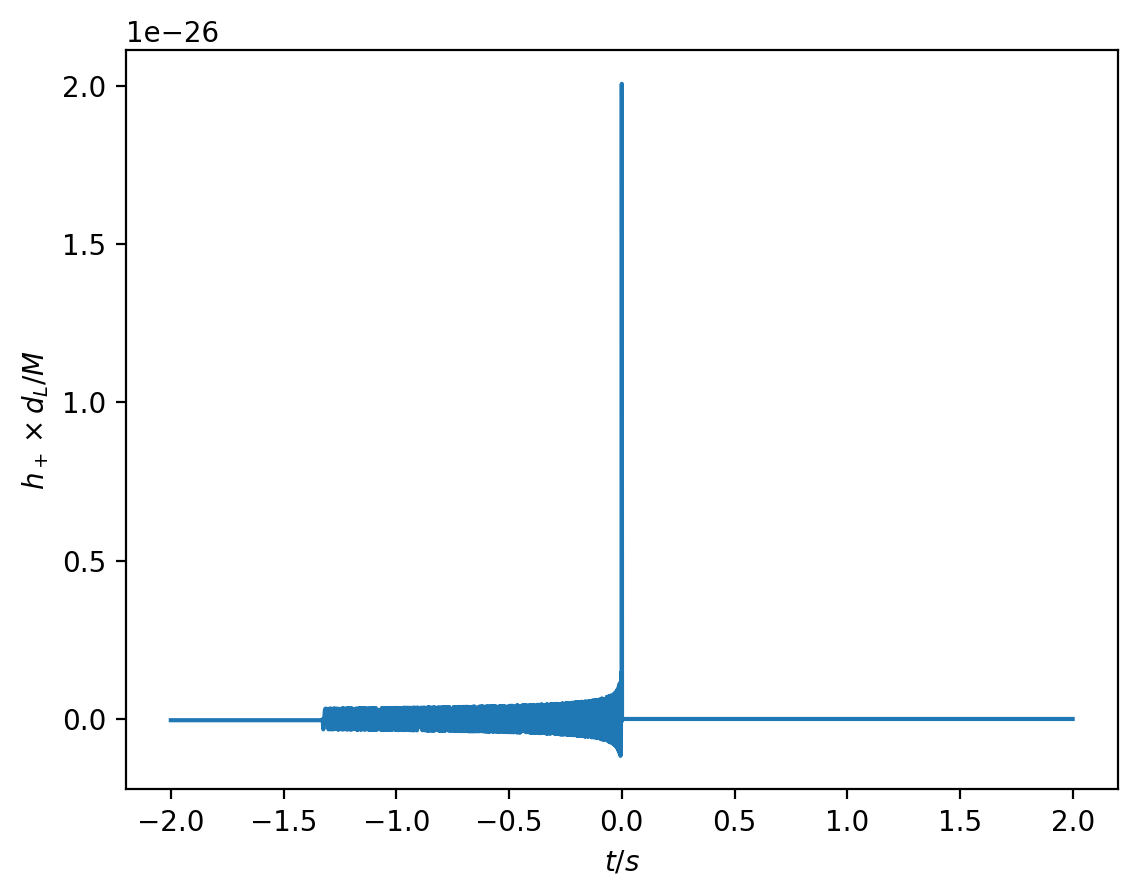

In [9]:
h, t = get_jaxnr_td(2048, 4, [0.0005, 400., 1, 0, 0])

plt.plot(t, h.real)
plt.xlabel("$t/s$")
plt.ylabel(r"$h_+ \times d_L/M$");

The best way to deal with this would be to let `model.make_waveform_kernel` itself window the waveform, if evaluated close to the edge. **TODO**

### Frequency domain

Now, modulo the corner case described above, we are ready to FFT the waveform. Down the line, we will want the FFT of the plus and cross polarizations, $\tilde{h}_{+/\times}$, evaluated over positive frequencies. We can make use of the symmetries of the complex strain $H(t) \equiv h_+ - i h_x$ to obtain both polarizations with a single FFT over both positive and negative frequencies.

First, compute the regular two-sided FFT by windowing the TD waveform produced above.

#### Complex-strain FFT

In [10]:
from scipy.signal.windows import tukey

def get_jaxnr_fd(*args, **kws):
    # Tukey parameter for windowing
    alpha = kws.pop('alpha', 0.4)
    
    # get TD waveform
    h_td, t = get_jaxnr_td(*args, **kws)
    
    # window and FFT
    h_fd = np.fft.fft(h_td*tukey(len(t), alpha))
    f = np.fft.fftfreq(len(t), t[1]-t[0])
    return h_fd, f, h_td, t

In [11]:
h_fd, f, h_td, t = get_jaxnr_fd(2048, 4, [70, 400., 1, 0, 0])
h_td_windowed = h_td*tukey(len(t), 0.4)

/mnt/home/misi/.virtualenvs/jaxnr/lib/python3.10/site-packages/jax/_src/array.py:341: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


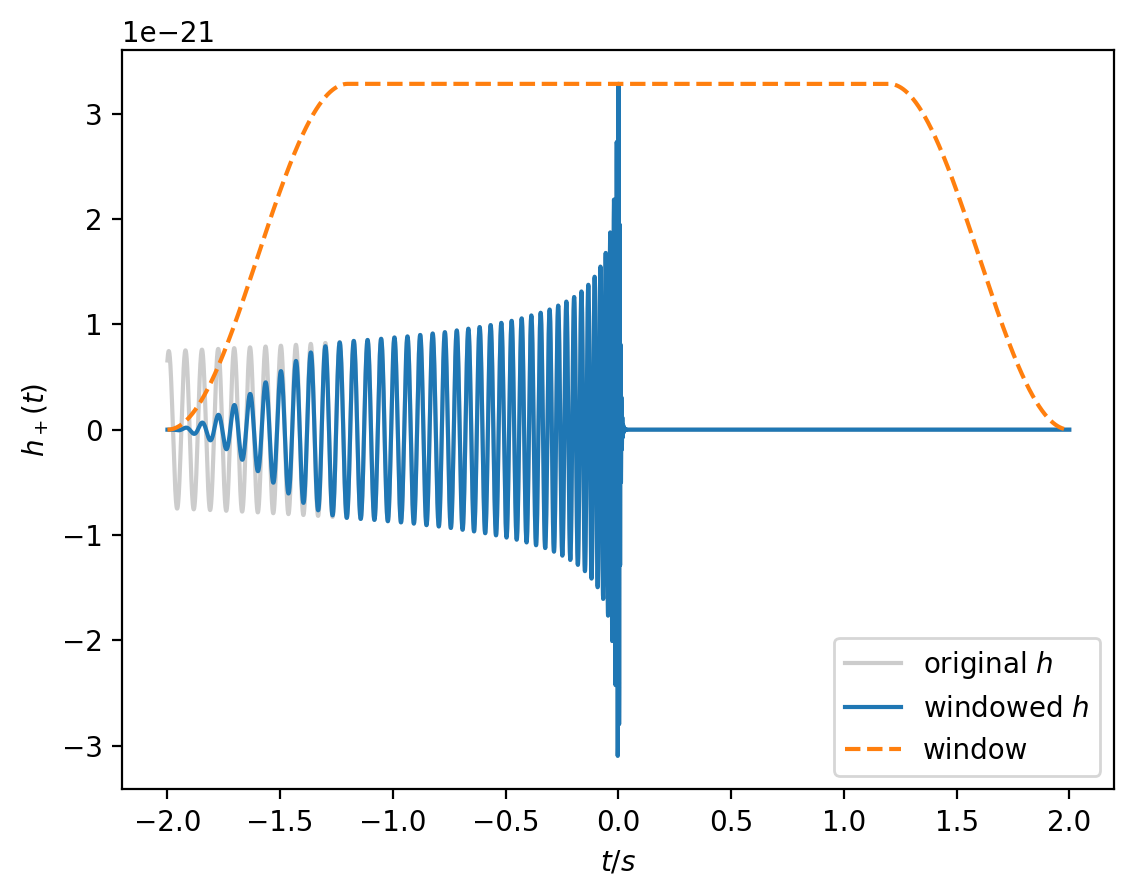

In [12]:
plt.plot(t, h_td.real, c='0.8', label='original $h$')
plt.plot(t, h_td_windowed, label='windowed $h$')
plt.plot(t, tukey(len(t), 0.4)*max(h_td.real), ls='--', label='window')
plt.xlabel("$t/s$")
plt.ylabel(r"$h_+(t)$")
plt.legend(loc='lower right');

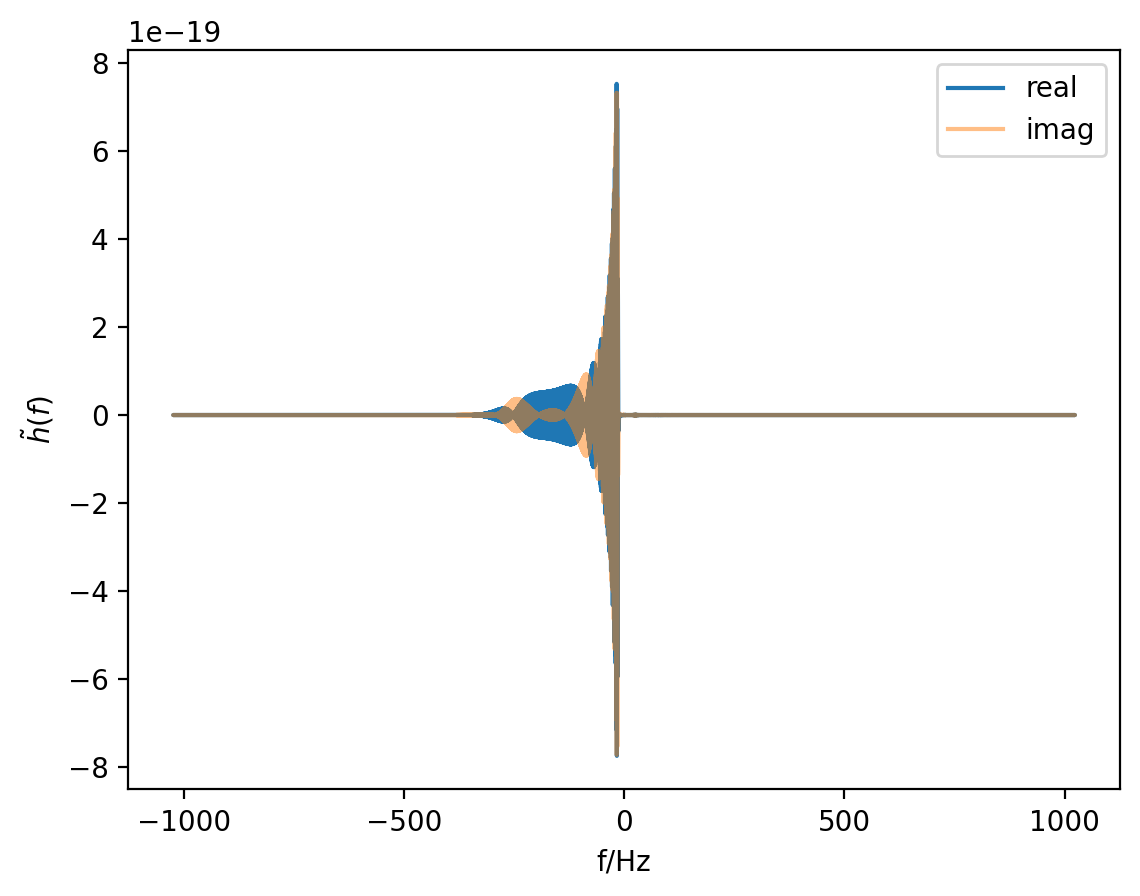

In [13]:
plt.plot(f, h_fd.real, label='real')
plt.plot(f, h_fd.imag, alpha=0.5, label='imag')
plt.xlabel("f/Hz")
plt.ylabel(r"$\tilde{h}(f)$")
plt.legend();

#### Individual polarizations

Based on the two-sided FFT of the complex strain, we can reconstructs the individual FD polarizations. The Fourier transform of $H(t)$, namely $\tilde{H}(f) = \tilde{h}_+(f) - i \tilde{h}_\times (f)$, contains all the information we need. We can see this by noting that, because $h_{+/\times}(t)$ are real-valued, then $\tilde{h}_{+/\times}(f) = \tilde{h}^*_{+/\times}(-f)$. Then,
$$
\tilde{H}(f) + \tilde{H}^*(-f) = \tilde{h}_+(f) - i \tilde{h}_\times (f) + \left[\tilde{h}^*_+(-f) + i \tilde{h}^*_\times (-f)\right] = 2\, \tilde{h}_+(f)
$$
and, similarly,
$$
\tilde{H}(f) - \tilde{H}^*(-f) = \tilde{h}_+(f) - i \tilde{h}_\times (f) + \left[- \tilde{h}^*_+(-f) - i \tilde{h}^*_\times (-f)\right] = - 2i\, \tilde{h}_\times(f)
$$
Therefore, we can get the FFT of the individual polarization functions as
$$
\tilde{h}_+(f) = \frac{1}{2} \left[ \tilde{H}(f) + \tilde{H}^*(-f) \right]~~,~~
\tilde{h}_\times(f) = \frac{i}{2} \left[ \tilde{H}(f) - \tilde{H}^*(-f) \right]
$$
We use that below.

In [14]:
def get_fd_pols(h_fd):
    # applies the transformation above, rolling the arrays to get the positive
    # and negative frequency components aligned correctly, as in np.fft.rfft
    n = len(h_fd)//2 + 1
    h_fd_positive = h_fd[:n]
    conj_h_fd_negative = np.conj(np.fft.ifftshift(h_fd))[:n][::-1]
    hp_fd = (h_fd_positive + conj_h_fd_negative)/2
    hc_fd = 1j*(h_fd_positive - conj_h_fd_negative)/2
    return hp_fd, hc_fd

As a sanity check, let's corroborate that this actually returns the same as computing the FFTs for plus and cross separately.

In [15]:
hp_fd_direct = np.fft.rfft(h_td_windowed.real)
hc_fd_direct = - np.fft.rfft(h_td_windowed.imag)
f_rfft = np.fft.rfftfreq(len(h_td_windowed), d=t[1]-t[0])

hp_fd, hc_fd = get_fd_pols(h_fd)

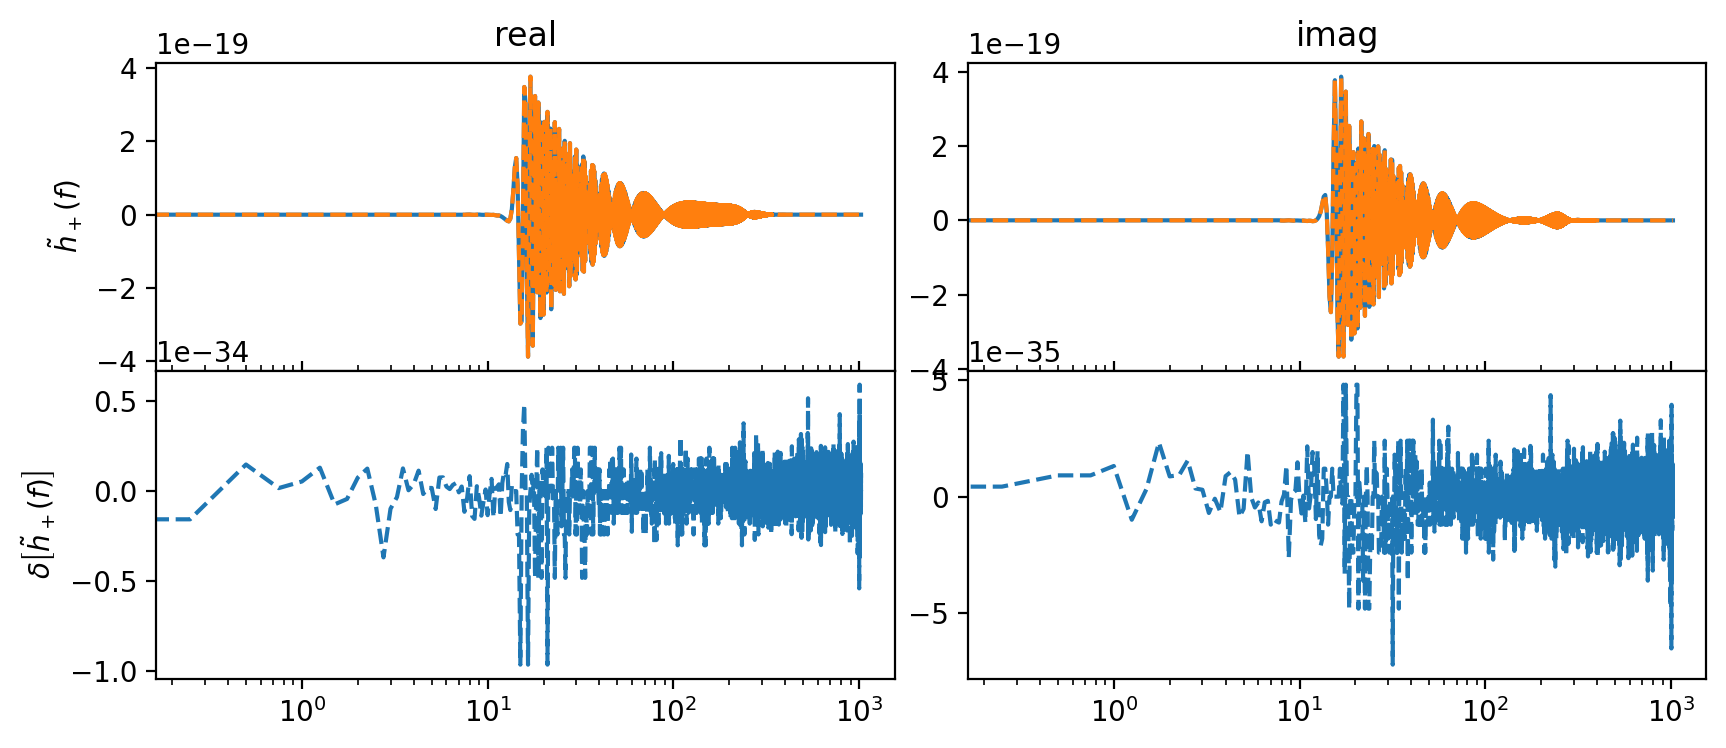

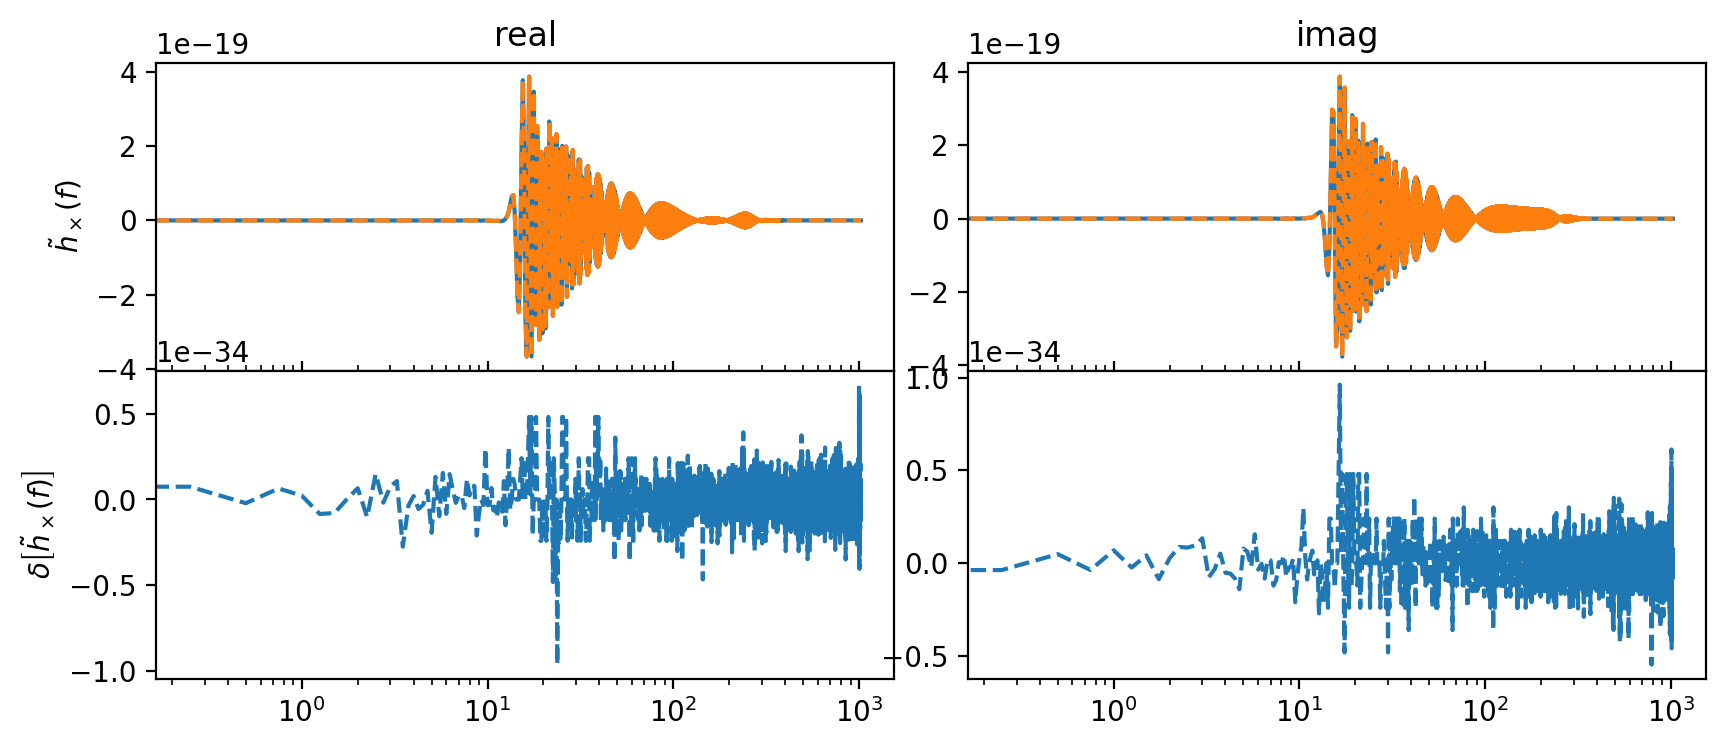

In [16]:
for hk, h_dir, h in [['+', hp_fd_direct, hp_fd], [r'\times', hc_fd_direct, hc_fd]]:
    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,4),
                        gridspec_kw=dict(hspace=0, wspace=0.1))

    axs[0,0].semilogx(f_rfft, h_dir.real)
    axs[0,0].semilogx(f_rfft, h.real, ls='--')
    axs[1,0].semilogx(f_rfft, h_dir.real - h.real, ls='--')

    axs[0,1].semilogx(f_rfft, h_dir.imag)
    axs[0,1].semilogx(f_rfft, h.imag, ls='--')
    axs[1,1].semilogx(f_rfft, h_dir.imag - h.imag, ls='--')

    for k, ax in zip(['real', 'imag'], axs[0]):
        ax.set_title(k)
        ax.tick_params(axis="x",direction="in", which='both')
    axs[0,0].set_ylabel(r"$\tilde{h}_%s(f)$" % hk)
    axs[1,0].set_ylabel(r"$\delta\left[\tilde{h}_%s(f)\right]$" % hk);

The difference is only due to numerics, so it all works.

## Jax wrappers

Let's wrap the above utilities into a Jax-friendly constructor.

In [17]:
import jax.numpy as jnp

In [18]:
def construct_nrsur(srate, seglen, tukey_alpha=0.4):
    # form time array with desired sampling rate and duration
    N = int(seglen*srate)
    n = N//2 + 1
    
    time = np.arange(N)/srate - seglen + 2
    
    # construct window for FFT
    window = tukey(N, tukey_alpha)
    
    def evaluate_nrsur(theta):
        mtot = theta[0]
        dist_mpc = theta[1]
        
        # evaluate the surrogate over the equivalent geometric time
        time_m = time * C_SI / RSUN_SI / mtot
        hrM = kernel(time_m, jnp.array(theta[2:]))
        
        # Fourier transform
        hrM_fd = jnp.fft.fft(hrM*window)
        
        # get FD plus and cross polarizations
        h_fd_positive = hrM_fd[:n]
        conj_h_fd_negative = jnp.conj(jnp.fft.ifftshift(h_fd))[:n][::-1]
        
        hp_rM_fd = (h_fd_positive + conj_h_fd_negative)/2
        hc_rM_fd = 1j*(h_fd_positive - conj_h_fd_negative)/2
        
        # this is h * r / M, so scale by the mass and distance        
        hp_fd = hp_rM_fd * mtot * RSUN_SI / dist_mpc / MPC_SI
        hc_fd = hc_rM_fd * mtot * RSUN_SI / dist_mpc / MPC_SI

        return hp_fd, hc_fd
    return evaluate_nrsur
        

In [19]:
# test
evaluate_nrsur = construct_nrsur(2048, 4)
evaluate_nrsur(jnp.array([70, 400., 1, 0, 0]))

(Array([-3.01612832e-23+1.03801391e-22j, -1.59025147e-23-2.60263419e-23j,
        -3.08274658e-23-2.01920373e-23j, ...,
         3.90926934e-25+7.13313854e-27j, -2.96634810e-25+3.41808284e-26j,
         4.87644695e-25-2.68353541e-25j], dtype=complex128),
 Array([-1.03801391e-22-3.01612832e-23j,  2.60263419e-23-1.59025147e-23j,
         2.01920373e-23-3.08274658e-23j, ...,
        -7.13313854e-27+3.90926934e-25j, -3.41808284e-26-2.96634810e-25j,
         2.68353541e-25+4.87644695e-25j], dtype=complex128))

In [20]:
def test(theta):
    hp, hc = evaluate_nrsur(jnp.array(theta))
    return jnp.sum(hp.real + hc.real)

In [23]:
f = jax.jit(test)
g = jax.grad(test)

In [30]:
%%timeit
f([70., 400., 1., 0., 0.])

3.67 ms ± 33 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
g([70., 400., 1., 0., 0.])

[Array(2.53422657e-22, dtype=float64, weak_type=True),
 Array(1.12466054e-24, dtype=float64, weak_type=True),
 Array(-1.48283011e-22, dtype=float64, weak_type=True),
 Array(-1.57958737e-21, dtype=float64, weak_type=True),
 Array(-1.54630241e-21, dtype=float64, weak_type=True)]